In [123]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

## Get files

In [124]:
path = '34759_final_project_rect/seq_01/'
labels = []
with open(path + 'labels.txt') as f:
    labels = f.readlines()

images_path = path + 'image_02/data/'
files = os.listdir(images_path)
files.sort()
n_images = len(files)

print(f"Files: {files}")
print(f"N_images: {n_images}")


Files: ['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png'

### BBOX functions

In [125]:
colors = {
    '0': (255, 0, 0), '1': (0, 255, 0), '2': (0, 0, 255), '3': (255, 255, 0), '4': (255, 0, 255),
    '5': (0, 255, 255), '6': (128, 0, 0), '7': (0, 128, 0), '8': (0, 0, 128), '9': (128, 128, 0),
    '10': (128, 0, 128), '11': (0, 128, 128), '12': (192, 192, 192), '13': (128, 128, 128),
    '14': (64, 0, 0), '15': (0, 64, 0), '16': (0, 0, 64), '17': (64, 64, 0), '18': (64, 0, 64),
    '19': (0, 64, 64), '20': (255, 128, 0), '21': (255, 0, 128), '22': (128, 255, 0), '23': (0, 255, 128),
    '24': (128, 0, 255), '25': (0, 128, 255), '26': (255, 128, 128), '27': (128, 255, 128),
    '28': (128, 128, 255), '29': (255, 255, 128), '30': (255, 128, 255), '31': (128, 255, 255),
    '32': (64, 128, 128), '33': (128, 64, 128), '34': (128, 128, 64), '35': (64, 64, 128),
    '36': (64, 128, 64), '37': (128, 64, 64), '38': (64, 64, 64), '39': (192, 64, 64),
    '40': (64, 192, 64), '41': (64, 64, 192), '42': (192, 192, 64), '43': (192, 64, 192),
    '44': (64, 192, 192), '45': (192, 128, 64), '46': (192, 64, 128), '47': (128, 192, 64),
    '48': (64, 128, 192), '49': (128, 64, 192), '50': (192, 128, 128), '51': (128, 192, 128),
    '52': (128, 128, 192), '53': (192, 192, 128), '54': (192, 128, 192), '55': (128, 192, 192)
}

def get_bbox(label):
    return [int(float(label[6])), int(float(label[7])), int(float(label[8])), int(float(label[9]))]

def draw_bbox(img, bbox, track_id):
    # if track_id not in colors:
    #     colors[track_id]
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), colors[track_id], 2)
    cv2.putText(img, track_id, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[track_id], 2)

def get_location(label):
    return [int(float(label[13])), int(float(label[14])), int(float(label[15]))]

### Kalman filter class

In [126]:
# kalman filter to track an object in 3D

fps = 30
dt = 1

class KalmanFilter:
    # The initial state. The robot starts in position 0 with the velocity 0.
    x = np.array([[0], # Position along the x-axis
                [0], # Velocity along the x-axis
                [0], # Position along the y-axis
                [0], # Velocity along the y-axis
                [0], # Position along the z-axis
                [0]]) # Velocity along the z-axis

    # The initial uncertainty. We start with some very large values.
    P = np.array([[1000, 0, 0, 0, 0, 0],
                [0, 1000, 0, 0, 0, 0],
                [0, 0, 1000, 0, 0, 0],
                [0, 0, 0, 1000, 0, 0],
                [0, 0, 0, 0, 1000, 0],
                [0, 0, 0, 0, 0, 1000]])

    # The external motion. Set to 0 here.
    u = np.array([[0],
                    [0],
                    [0],
                    [0],
                    [0],
                    [0]])

    # The transition matrix. 
    F = np.array([[1, dt, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, dt, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, dt],
                [0, 0, 0, 0, 0, 1]])

    # The observation matrix. We only get the position as measurement.
    H = np.array([[1, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 1, 0]])

    # The measurement uncertainty
    R = 20

    # The identity matrix. Simply a matrix with 1 in the diagonal and 0 elsewhere.
    I = np.array([[1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 1]])
    
    def __init__(self, id, x, y, z):
        self.id = id
        self.x[0] = x
        self.x[2] = y
        self.x[4] = z

    def update(self, Z):
        ### Insert update function
        y = Z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), np.transpose(self.H)) + self.R
        K = np.dot(np.dot(self.P, np.transpose(self.H)), np.linalg.pinv(S))
        x_p = self.x + np.dot(K, y)
        P_p = np.dot((self.I - np.dot(K, self.H)), self.P)

        self.x = x_p
        self.P = P_p

        
    def predict(self):
        ### insert predict function
        x_p = np.dot(self.F, self.x) + self.u
        P_p = np.dot(np.dot(self.F, self.P), np.transpose(self.F))

        self.x = x_p
        self.P = P_p


In [127]:
karlman_filters = {}
ids_to_track = []  # List of IDs to track - If empty, all IDs are tracked

def plot_point(ax, x, z, color, track_id, marker='o'):
    """Plots a point with text annotation on the specified axis."""
    ax.scatter(x, z, color=color, marker=marker)
    ax.text(x, z, track_id, fontsize=12, color=color)

def update_kalman(track_id, x, y, z):
    """Updates the Kalman filter for a given track_id and returns the filtered state."""
    x_kalman = np.array([[x], [y], [z]])
    if track_id not in karlman_filters:
        karlman_filters[track_id] = KalmanFilter(track_id, x, y, z)
    karlman_filters[track_id].predict()
    karlman_filters[track_id].update(x_kalman)
    return karlman_filters[track_id].x

### Play video

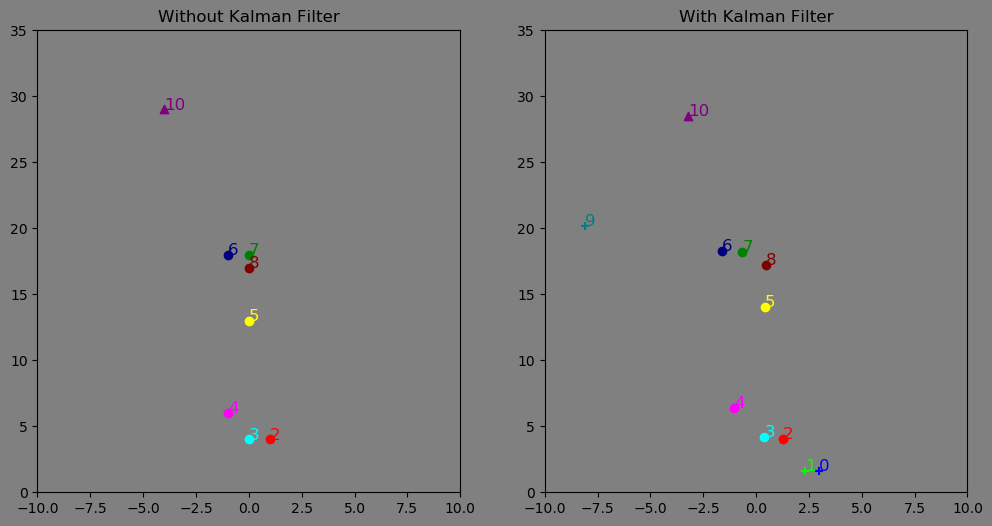

In [128]:
# Create the figure and axes once
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Set grey background for the plots
fig.patch.set_facecolor('grey')
ax1.set_facecolor('grey')
ax2.set_facecolor('grey')

# Make a copy of the labels to avoid modifying the original

continue_loop = True
while continue_loop:
    karlman_filters = {}
    labels_copy = labels.copy()
    for i in range(n_images):
        img = cv2.imread(images_path + files[i])
        ax1.clear()
        ax2.clear()
        clear_output(wait=True)

        to_remove = []

        for idx, label in enumerate(labels_copy):
            label = label.split(' ')
            if int(label[0]) != i:
                break
            
            track_id = label[1]
            if ids_to_track and track_id not in ids_to_track:
                continue

            # Get bounding box and location
            bbox = get_bbox(label)
            draw_bbox(img, bbox, track_id)
            x, y, z = get_location(label)

            # Update Kalman filter and get filtered coordinates
            x_kalman = update_kalman(track_id, x, y, z)
            
            # Define color for the track_id and determine marker based on object type
            color = np.array(colors[track_id])[::-1] / 255.0
            object_type = label[2]
            marker = {'Car': 'c', 'Pedestrian': 'o', 'Cyclist': '^'}.get(object_type, 'o')
            
            # Plot points on both axes with and without Kalman filter
            plot_point(ax1, x, z, color, track_id, marker)
            plot_point(ax2, x_kalman[0], x_kalman[4], color, track_id, marker)
            
            # Mark label as processed
            to_remove.append(idx)

        # For the ids that were not found in the current frame, just predict the next state
        for track_id in karlman_filters:
            if track_id not in [label.split(' ')[1] for label in labels_copy]:
                karlman_filters[track_id].predict()
                color = np.array(colors[track_id])[::-1] / 255.0
                object_type = label[2]
                marker = '+'
                plot_point(ax2, karlman_filters[track_id].x[0], karlman_filters[track_id].x[4], color, track_id, marker)
        
        # Remove processed labels from labels_copy
        labels_copy = [label for idx, label in enumerate(labels_copy) if idx not in to_remove]

        # Display image and manage keyboard interruption
        cv2.imshow('image', img)
        if cv2.waitKey(100) == 27:
            continue_loop = False
            break

        # Update and display the plot
        for ax, title in zip([ax1, ax2], ["Without Kalman Filter", "With Kalman Filter"]):
            ax.set_xlim(-10, 10)
            ax.set_ylim(0, 35)
            ax.set_title(title)
        
        display(fig)
        plt.pause(0.01)  # Small pause for real-time update in Jupyter

cv2.destroyAllWindows()


### 3D visualization

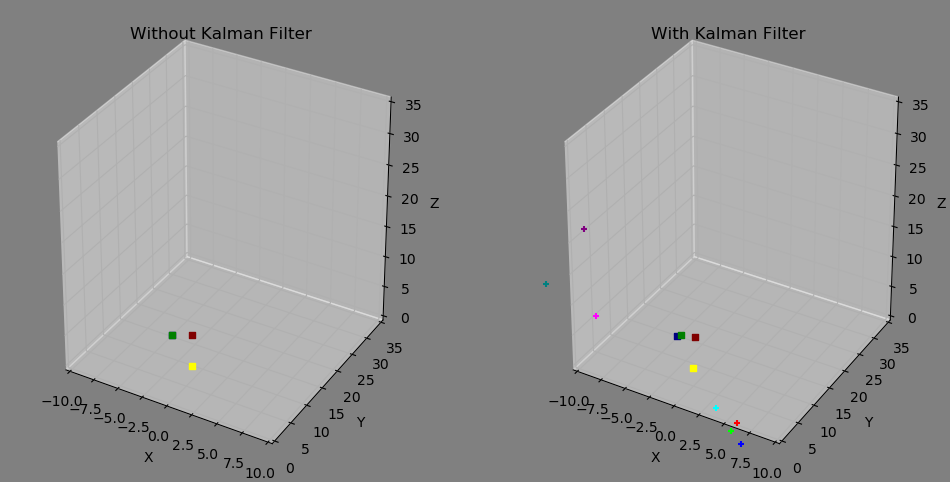

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module
# Create the figure and axes once (for 3D plotting)
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')  # 3D axis for original tracking
ax2 = fig.add_subplot(122, projection='3d')  # 3D axis for Kalman-filtered tracking

# Set grey background for the plots
fig.patch.set_facecolor('grey')
ax1.set_facecolor('grey')
ax2.set_facecolor('grey')

continue_loop = True
while continue_loop:
    karlman_filters = {}
    labels_copy = labels.copy()
    for i in range(n_images):
        img = cv2.imread(images_path + files[i])
        ax1.clear()
        ax2.clear()
        clear_output(wait=True)

        to_remove = []

        for idx, label in enumerate(labels_copy):
            label = label.split(' ')
            if int(label[0]) != i:
                break

            track_id = label[1]
            if ids_to_track and track_id not in ids_to_track:
                continue

            # Get bounding box and location
            bbox = get_bbox(label)
            draw_bbox(img, bbox, track_id)
            x, y, z = get_location(label)

            # Update Kalman filter and get filtered coordinates
            x_kalman = update_kalman(track_id, x, y, z)
            
            # Define color for the track_id and determine marker based on object type
            color = np.array(colors[track_id])[::-1] / 255.0
            object_type = label[2]
            marker = {'Car': 'o', 'Pedestrian': 's', 'Cyclist': '^'}.get(object_type, 'o')
            
            # Plot points on both axes (3D) with and without Kalman filter
            ax1.scatter(x, y, z, c=[color], label=track_id, marker=marker)
            ax2.scatter(x_kalman[0], x_kalman[1], x_kalman[4], c=[color], label=track_id, marker=marker)

            # Mark label as processed
            to_remove.append(idx)

        # For the ids that were not found in the current frame, just predict the next state
        for track_id in karlman_filters:
            if track_id not in [label.split(' ')[1] for label in labels_copy]:
                karlman_filters[track_id].predict()
                color = np.array(colors[track_id])[::-1] / 255.0
                ax2.scatter(karlman_filters[track_id].x[0], karlman_filters[track_id].x[1], karlman_filters[track_id].x[4],
                            c=[color], label=track_id, marker='+')

        # Remove processed labels from labels_copy
        labels_copy = [label for idx, label in enumerate(labels_copy) if idx not in to_remove]

        # Display image and manage keyboard interruption
        cv2.imshow('image', img)
        if cv2.waitKey(100) == 27:
            continue_loop = False
            break

        # Update and display the plot (3D)
        for ax, title in zip([ax1, ax2], ["Without Kalman Filter", "With Kalman Filter"]):
            ax.set_xlim(-10, 10)
            ax.set_ylim(0, 35)
            ax.set_zlim(0, 35)
            ax.set_title(title)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

        display(fig)
        plt.pause(0.01)  # Small pause for real-time update in Jupyter

cv2.destroyAllWindows()
